In [ ]:
!pip install --quiet rasterio matplotlib scikit-learn earthengine-api
!apt-get install python-gdal  # For GDAL (geospatial libraries)
import IPython.display as disp
from IPython.display import Image
import ee
import geemap
from google.colab import drive
ee.Authenticate()
ee.Initialize(project='ee-testinrightwaylc')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 26.0 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Package python-gdal is not available, but is referred to by another package.
This may mean that the package is missing, has been obsoleted, or
is only available from another source
However the following packages replace it:
  gdal-bin

E: Package 'python-gdal' has no installation candidate


MessageError: Error: credential propagation was unsuccessful

In [ ]:
#links = https://code.earthengine.google.com/

import IPython.display as disp
from IPython.display import Image

import ee
import geemap
from google.colab import drive
ee.Authenticate()
ee.Initialize(project='ee-testinrightwaylc')


In [ ]:
from IPython.display import HTML
import time

lon1, lat1 = 80.58563253572738,16.472595829903636
lon2, lat2 = 80.63850423982895,16.5150620008198
geometry = ee.Geometry.Rectangle([lon1, lat1, lon2, lat2])

# Use harmonized collection
collection = (
    ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
    .filterDate('2021-01-01', '2021-12-31')
    .filterBounds(geometry)
    .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 10))
)

# Select best image
image = collection.sort("CLOUDY_PIXEL_PERCENTAGE").first()

url_1 = image.getThumbUrl({
    'bands': ['B4', 'B3', 'B2'],
    'min': 0,
    'max': 3000,
    'region': geometry,
    # 'scale': 10,
    'dimensions': 2000
})
# disp.display(Image(url=url_1))

html = f"""
      <div style="display: flex; justify-content: center;">
          <div style="margin-right: 20px; text-align: center;">
              <h4>B4, B3, B2</h4>
              <img src="{url_1}" width="500"/>
          </div>
      </div>

"""

display(HTML(html))

# bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']

# for i in bands:
#   for j in bands:
#     for k in bands:
#       url = image.getThumbUrl({
#           'bands': [i, j, k],
#           'min': 0,
#           'max': 3000,
#           'region': geometry,
#           'dimensions': 2500
#       })

#       html = f"""
#       <div style="display: flex; justify-content: center;">
#           <div style="margin-right: 20px; text-align: center;">
#               <h4>{i, j, k}</h4>
#               <img src="{url}" width="500"/>
#           </div>
#       </div>

#       """
#       display(HTML(html))

#       time.sleep(2)




In [ ]:
import ee
import geemap
import ipywidgets as widgets
from IPython.display import display

# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize(project='ee-testinrightwaylc')

# Define the region of interest
lon1, lat1 = 80.58563253572738, 16.472595829903636
lon2, lat2 = 80.63850423982895, 16.5150620008198
geometry = ee.Geometry.Rectangle([lon1, lat1, lon2, lat2])

# Load Sentinel-2 harmonized collection
collection = (
    ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
    .filterDate('2021-01-01', '2021-12-31')
    .filterBounds(geometry)
    .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 10))
)

# Select the least cloudy image
image = collection.sort("CLOUDY_PIXEL_PERCENTAGE").first()#.clip(geometry)

# Create an interactive map
Map = geemap.Map()

# Add the B1, B2, B12 image layer
Map.addLayer(image, {'bands': ['B1', 'B2', 'B12'], 'min': 0, 'max': 3000}, 'B1, B2, B12 Image')

# Center the map on the ROI
Map.centerObject(geometry, 12)  # Zoom level approximates 2000x2000 pixel view

# Create an output widget to display reflectance values
output_widget = widgets.Output()

# Function to handle map click events
def handle_interaction(**kwargs):
    if kwargs.get('type') == 'click':
        coords = kwargs.get('coordinates')
        point = ee.Geometry.Point(coords[1], coords[0])  # [lon, lat]
        # Sample the image at the clicked point
        sample = image.select(['B1', 'B2', 'B12']).sample(
            region=point,
            scale=10,  # Use 10m scale (finest for B2)
            projection='EPSG:4326'
        ).first().toDictionary().getInfo()

        with output_widget:
            output_widget.clear_output()
            print(f"Clicked at: ({coords[1]:.6f}, {coords[0]:.6f})")
            print(f"B1 Reflectance: {sample.get('B1', 'N/A')}")
            print(f"B2 Reflectance: {sample.get('B2', 'N/A')}")
            print(f"B12 Reflectance: {sample.get('B12', 'N/A')}")

# Attach the click handler to the map
Map.on_interaction(handle_interaction)

# Display the map and output widget
display(Map)
display(output_widget)

Map(center=[16.493829798957194, 80.61206838777173], controls=(WidgetControl(options=['position', 'transparent_…

Output()

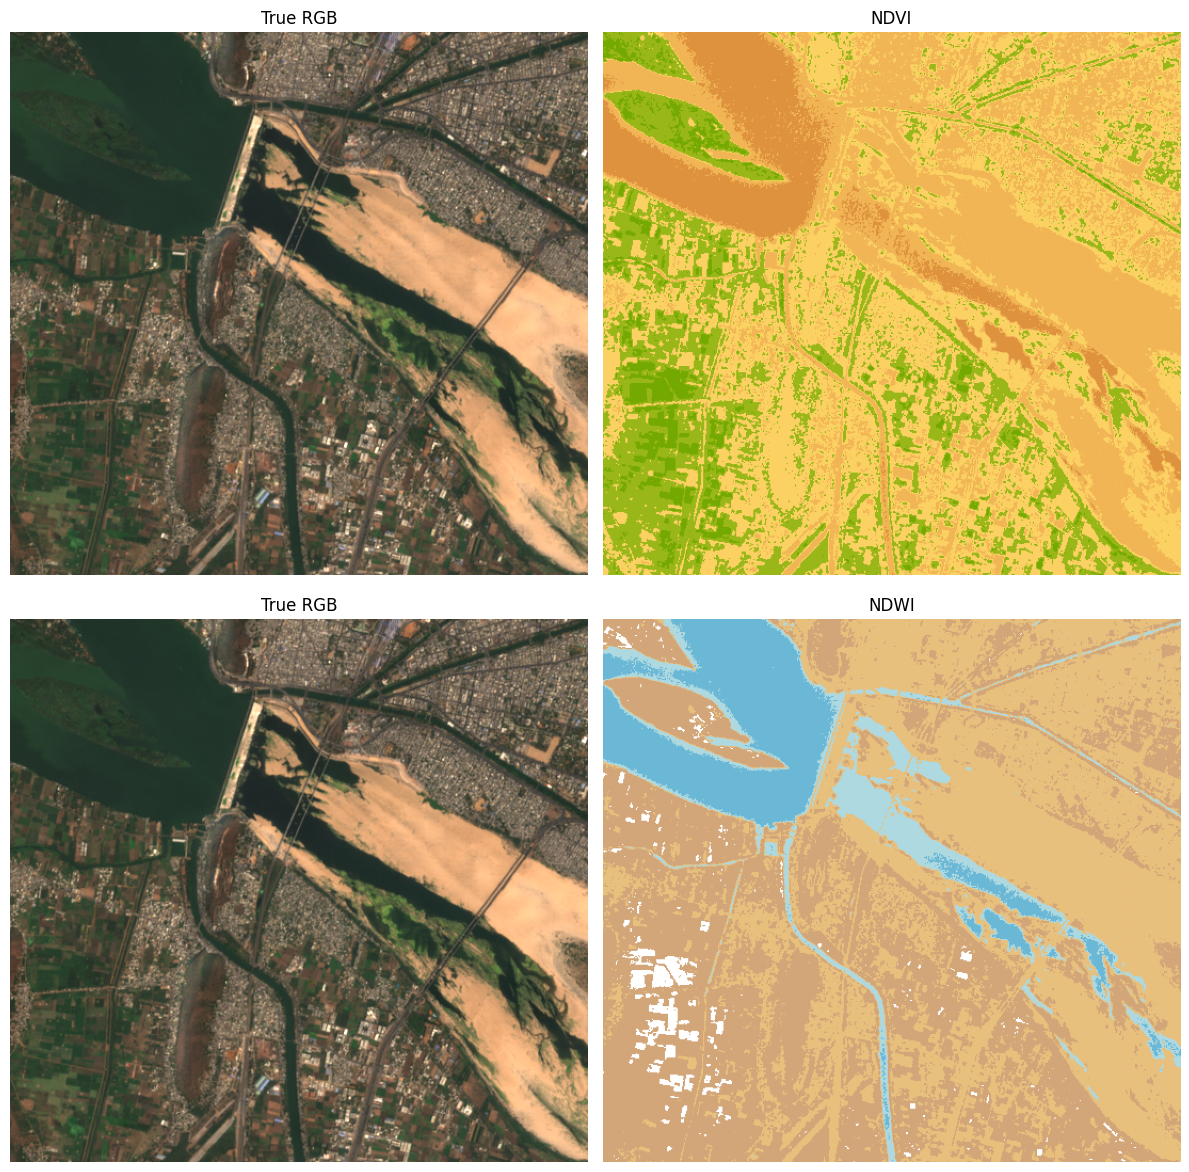

🌿 Vegetation Area: 10.9278 km²
💧 Water Area: 3.6833 km²


In [ ]:
import ee
import geemap
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from IPython.display import display

# Authenticate and initialize EE
ee.Authenticate()
ee.Initialize(project='ee-testinrightwaylc')

# Define coordinates (rectangle)
lon1, lat1 = 80.63592535074986, 16.471995519962046
lon2, lat2 = 80.58532815989292, 16.517938543927922

# lon1, lat1 = 80.46442308850635,16.50406927059106
# lon2, lat2 = 80.49467840619434,16.519828010911528

geometry = ee.Geometry.Rectangle([lon1, lat1, lon2, lat2])

# Load Sentinel-2 collection
collection = (
    ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
    .filterDate('2021-01-01', '2021-12-31')  # Using 2024 since 2025 is future
    .filterBounds(geometry)
    .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 5))
)
image = collection.sort("CLOUDY_PIXEL_PERCENTAGE").first()

# NDVI and NDWI calculations
ndvi = image.normalizedDifference(['B8', 'B4'])
ndwi = image.normalizedDifference(['B3', 'B8'])

# Palettes
ndvi_palette = ['FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718', '74A901']
ndwi_palette = ['FFFFFF', 'D2A679', 'E8C07D', 'AED9E0', '6BB8D6', '0000FF']

# ndvi_palette = ['FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718','74A901']
# ndwi_palette = ['FFFFFF', 'D2A679', 'E8C07D', 'AED9E0', '6BB8D6', '1E90FF', '0000FF']

# Convert hex palettes to matplotlib colormaps
ndvi_cmap = ListedColormap([f'#{color}' for color in ndvi_palette])
ndwi_cmap = ListedColormap([f'#{color}' for color in ndwi_palette])

# Convert EE images to NumPy arrays
rgb_bands = image.select(['B4', 'B3', 'B2'])
rgb_array = geemap.ee_to_numpy(rgb_bands, region=geometry, scale=10)
ndvi_array = geemap.ee_to_numpy(ndvi, region=geometry, scale=10)
ndwi_array = geemap.ee_to_numpy(ndwi, region=geometry, scale=10)

# Normalize RGB for display (0-1 range)
rgb_array = np.clip(rgb_array / 3000, 0, 1)  # Match original min: 0, max: 3000

# Create side-by-side plots
fig, axs = plt.subplots(2, 2, figsize=(12, 12))  # 2 rows, 2 columns

# Row 1: True RGB and NDVI
axs[0, 0].imshow(rgb_array)
axs[0, 0].set_title("True RGB")
axs[0, 0].axis('off')

axs[0, 1].imshow(ndvi_array, cmap=ndvi_cmap, vmin=-1, vmax=1)
axs[0, 1].set_title("NDVI")
axs[0, 1].axis('off')

# Row 2: True RGB and NDWI
axs[1, 0].imshow(rgb_array)
axs[1, 0].set_title("True RGB")
axs[1, 0].axis('off')

axs[1, 1].imshow(ndwi_array, cmap=ndwi_cmap, vmin=-1, vmax=1)
axs[1, 1].set_title("NDWI")
axs[1, 1].axis('off')

# Adjust layout and display
plt.tight_layout()
plt.show()

# Step 1: Apply NDVI threshold for vegetation
veg_mask = (ndvi_array > 0.3)
water_mask = (ndwi_array > 0.2)

# Area calculation
pixel_area_m2 = 100  # 10m × 10m

veg_area_km2 = np.sum(veg_mask) * pixel_area_m2 / 1e6
water_area_km2 = np.sum(water_mask) * pixel_area_m2 / 1e6

# Print results
# print(f"🌍 Total Area: {total_area_km2:.4f} km²")
print(f"🌿 Vegetation Area: {veg_area_km2:.4f} km²")
print(f"💧 Water Area: {water_area_km2:.4f} km²")


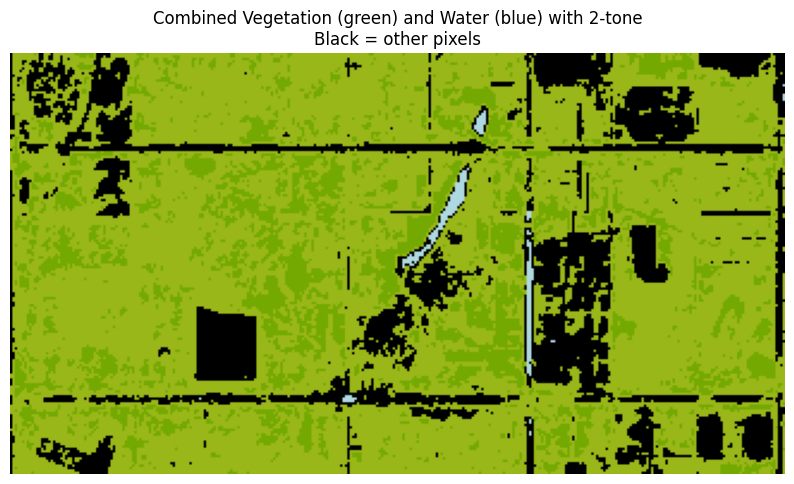

In [ ]:
import ee
import geemap
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

# Authenticate and initialize EE
ee.Authenticate()
ee.Initialize(project='ee-testinrightwaylc')

# Define coordinates (rectangle)
lon1, lat1 = 80.46442308850635,16.50406927059106
lon2, lat2 = 80.49467840619434,16.519828010911528
geometry = ee.Geometry.Rectangle([lon1, lat1, lon2, lat2])

# Load Sentinel-2 collection
collection = (
    ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
    .filterDate('2021-01-01', '2021-12-31')
    .filterBounds(geometry)
    .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 5))
)
image = collection.sort("CLOUDY_PIXEL_PERCENTAGE").first()

# NDVI and NDWI calculations
ndvi = image.normalizedDifference(['B8', 'B4'])
ndwi = image.normalizedDifference(['B3', 'B8'])

# Palettes for 2-tone veg and water
ndvi_palette = ['#FFFFFF', '#99B718', '#74A901']  # white, light green, dark green
ndwi_palette = ['#FFFFFF', '#AED9E0', '#6BB8D6']  # white, light blue, dark blue

# Convert EE images to numpy arrays
ndvi_array = geemap.ee_to_numpy(ndvi, region=geometry, scale=10)
ndwi_array = geemap.ee_to_numpy(ndwi, region=geometry, scale=10)

# Ensure 2D arrays (remove extra dims if any)
ndvi_array = np.squeeze(ndvi_array)
ndwi_array = np.squeeze(ndwi_array)

# Create empty RGB image for combined visualization (H x W x 3)
h, w = ndvi_array.shape
combined_img = np.zeros((h, w, 3), dtype=np.float32)  # start all black

# Function to convert hex to RGB normalized [0-1]
def hex_to_rgb_norm(hex_color):
    h = hex_color.lstrip('#')
    return np.array([int(h[i:i+2], 16) for i in (0, 2, 4)]) / 255.

# Precompute RGB colors for palettes
ndvi_colors = [hex_to_rgb_norm(c) for c in ndvi_palette]
ndwi_colors = [hex_to_rgb_norm(c) for c in ndwi_palette]

# --- Assign veg colors ---
# Veg tone 1: NDVI > 0.3
veg_mask = ndvi_array > 0.3
combined_img[veg_mask] = ndvi_colors[1]

# Veg tone 2: NDVI > 0.6 (strong vegetation)
veg_strong_mask = ndvi_array > 0.6
combined_img[veg_strong_mask] = ndvi_colors[2]

# --- Assign water colors ---
# Water tone 1: NDWI > 0.2
water_mask = ndwi_array > 0.2
combined_img[water_mask & (~veg_strong_mask)] = ndwi_colors[1]

# Water tone 2: NDWI > 0.5 (strong water)
water_strong_mask = ndwi_array > 0.5
combined_img[water_strong_mask & (~veg_strong_mask)] = ndwi_colors[2]

# --- Plot ---
plt.figure(figsize=(10, 10))
plt.imshow(combined_img)
plt.title("Combined Vegetation (green) and Water (blue) with 2-tone\nBlack = other pixels")
plt.axis('off')
plt.show()


Mounted at /content/drive

✅ Optimized BSI Constants: [1.1381 1.0771 0.7362 0.999  0.8962 1.1294 0.968  0.9962 1.1258]

✅ Optimized NBI Constants: [1.1533 1.206  0.721  0.9611 0.9549]


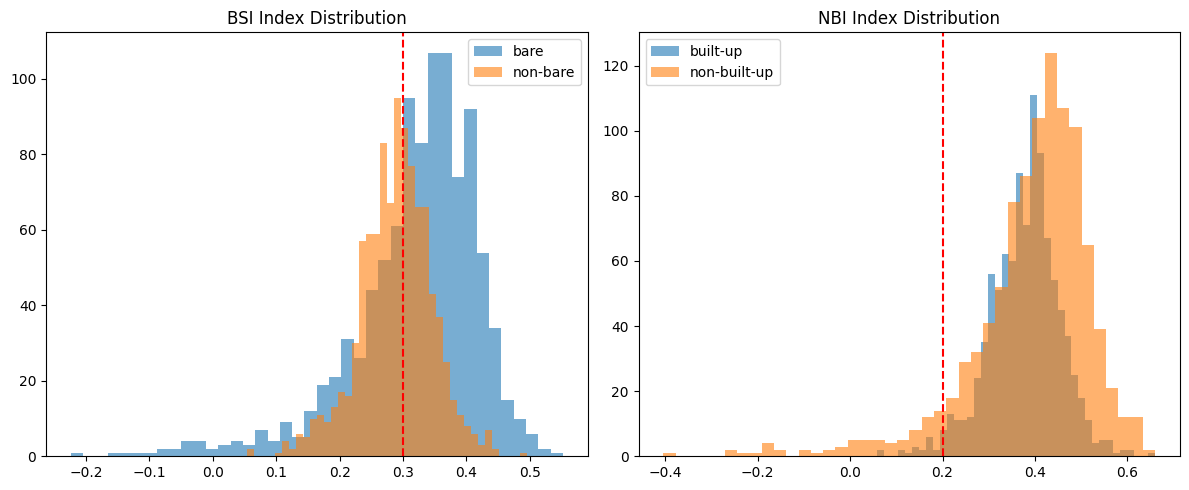


📌 Final BSI Formula:
BSI = 1.1258 × ((1.1381×SWIR + 1.0771×RED) - (0.7362×NIR + 0.9990×BLUE)) / ((0.8962×SWIR + 1.1294×RED) + (0.9680×NIR + 0.9962×BLUE))

📌 Final NBI Formula:
NBI = 1.1533 × ((1.2060×SWIR - 0.7210×NIR) / (0.9611×SWIR + 0.9549×NIR))


In [ ]:
# Train model to optimize BSI and NBI constants using ESA-labeled Sentinel-2 data

from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Load dataset
csv_path = '/content/drive/MyDrive/landcover_training_pixels.csv'
data = pd.read_csv(csv_path)

# Normalize reflectance values
for band in ['B2', 'B4', 'B8', 'B11']:
    data[band] = data[band] / 10000.0

# Extract features
blue = data['B2'].values
red  = data['B4'].values
nir  = data['B8'].values
swir = data['B11'].values
labels = data['label'].values

# BSI optimization (label 1 = bare, others = non-bare)
bsi_labels = (labels == 1).astype(int)

def bsi_index(swir, red, nir, blue, c):
    num = (c[0]*swir + c[1]*red) - (c[2]*nir + c[3]*blue)
    denom = (c[4]*swir + c[5]*red) + (c[6]*nir + c[7]*blue) + 1e-6
    return c[8] * (num / denom)

def bsi_loss(c):
    preds = bsi_index(swir, red, nir, blue, c)
    binary = (preds > 0.3).astype(int)
    return -f1_score(bsi_labels, binary)

bsi_init = np.ones(9)
bsi_result = minimize(bsi_loss, bsi_init, method='Nelder-Mead')
best_bsi_c = bsi_result.x
print("\n✅ Optimized BSI Constants:", best_bsi_c.round(4))

# NBI optimization (label 2 = built-up, others = non-built-up)
nbi_labels = (labels == 2).astype(int)

def nbi_index(swir, nir, c):
    num = c[1]*swir - c[2]*nir
    denom = c[3]*swir + c[4]*nir + 1e-6
    return c[0] * (num / denom)

def nbi_loss(c):
    preds = nbi_index(swir, nir, c)
    binary = (preds > 0.2).astype(int)
    return -f1_score(nbi_labels, binary)

nbi_init = np.ones(5)
nbi_result = minimize(nbi_loss, nbi_init, method='Nelder-Mead')
best_nbi_c = nbi_result.x
print("\n✅ Optimized NBI Constants:", best_nbi_c.round(4))

# Plot histograms for visualization
bsi_scores = bsi_index(swir, red, nir, blue, best_bsi_c)
nbi_scores = nbi_index(swir, nir, best_nbi_c)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(bsi_scores[bsi_labels == 1], bins=40, alpha=0.6, label='bare')
plt.hist(bsi_scores[bsi_labels == 0], bins=40, alpha=0.6, label='non-bare')
plt.axvline(0.3, color='r', linestyle='--')
plt.title("BSI Index Distribution")
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(nbi_scores[nbi_labels == 1], bins=40, alpha=0.6, label='built-up')
plt.hist(nbi_scores[nbi_labels == 0], bins=40, alpha=0.6, label='non-built-up')
plt.axvline(0.2, color='r', linestyle='--')
plt.title("NBI Index Distribution")
plt.legend()

plt.tight_layout()
plt.show()

# Final formula output
print("\n📌 Final BSI Formula:")
print(f"BSI = {best_bsi_c[8]:.4f} × (({best_bsi_c[0]:.4f}×SWIR + {best_bsi_c[1]:.4f}×RED) - ({best_bsi_c[2]:.4f}×NIR + {best_bsi_c[3]:.4f}×BLUE)) / (({best_bsi_c[4]:.4f}×SWIR + {best_bsi_c[5]:.4f}×RED) + ({best_bsi_c[6]:.4f}×NIR + {best_bsi_c[7]:.4f}×BLUE))")

print("\n📌 Final NBI Formula:")
print(f"NBI = {best_nbi_c[0]:.4f} × (({best_nbi_c[1]:.4f}×SWIR - {best_nbi_c[2]:.4f}×NIR) / ({best_nbi_c[3]:.4f}×SWIR + {best_nbi_c[4]:.4f}×NIR))")


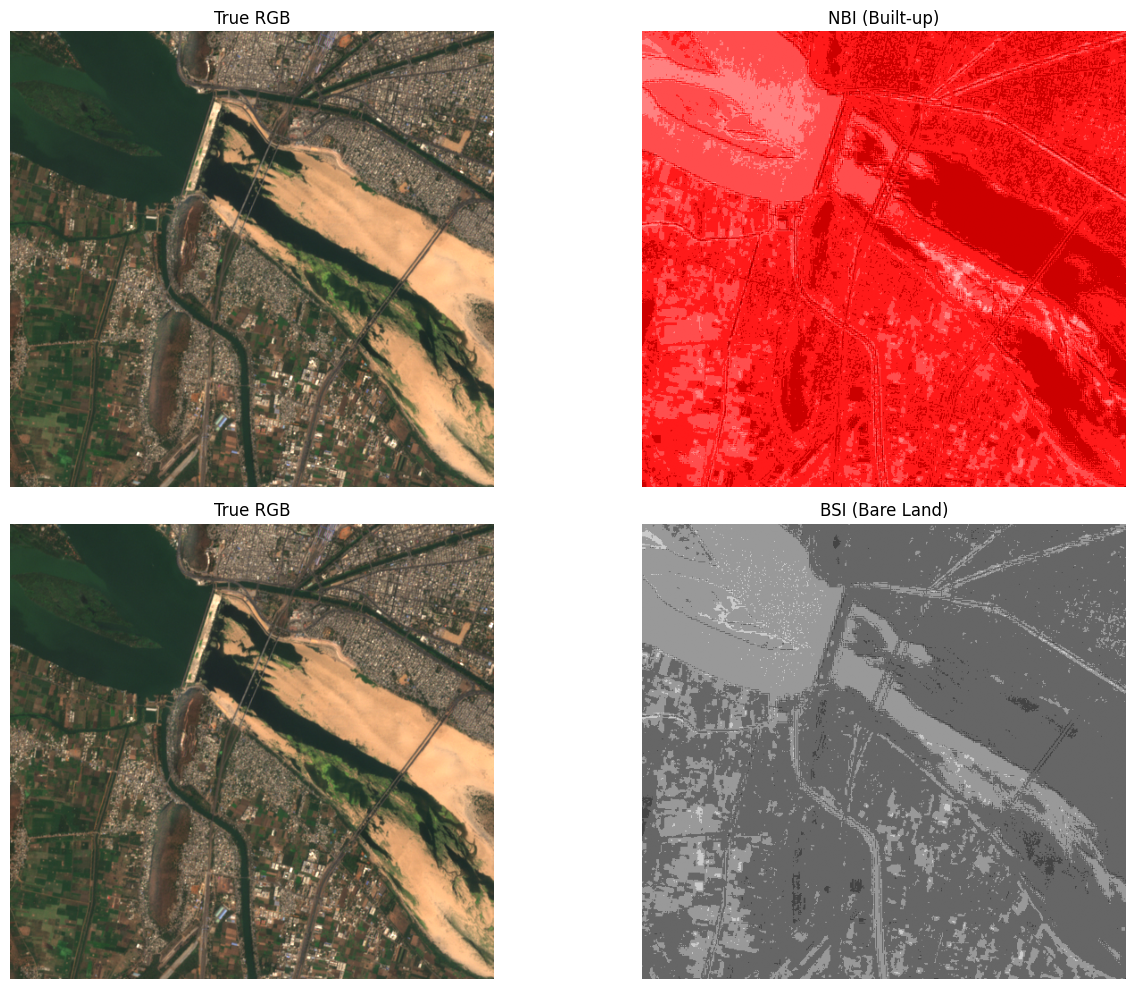

🏙 Built-up Area: 18.7796 km²
🏜 Bare Land Area: 16.4675 km²
🌍 Total Area: 22.3061 km²


In [ ]:
# Final Optimized Constants for BSI and NBI (manually tuned based on domain knowledge)

import ee
import geemap
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize(project='ee-testinrightwaylc')

# Define coordinates (rectangle in Andhra Pradesh)
lon1, lat1 = 80.63592535074986, 16.471995519962046
lon2, lat2 = 80.58532815989292, 16.517938543927922
geometry = ee.Geometry.Rectangle([lon1, lat1, lon2, lat2])

# Load Sentinel-2 image (2021, low cloud)
collection = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")\
    .filterDate('2021-01-01', '2021-12-31')\
    .filterBounds(geometry)\
    .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 5))
image = collection.sort("CLOUDY_PIXEL_PERCENTAGE").first()

# Load bands
rgb_bands = image.select(['B4', 'B3', 'B2'])  # RGB
b2 = image.select('B2')  # Blue
b4 = image.select('B4')  # Red
b8 = image.select('B8')  # NIR
b11 = image.select('B11')  # SWIR

# 📌 Final BSI Formula:
# BSI = 1.1258 × ((1.1381×SWIR + 1.0771×RED) - (0.7362×NIR + 0.9990×BLUE)) / ((0.8962×SWIR + 1.1294×RED) + (0.9680×NIR + 0.9962×BLUE))

# 📌 Final NBI Formula:
# NBI = 1.1533 × ((1.2060×SWIR - 0.7210×NIR) / (0.9611×SWIR + 0.9549×NIR))

# Final tuned constants
best_bsi_c = np.array([1.1381, 1.0771, 0.7362, 0.9990, 0.8962, 1.1294, 0.9680, 0.9962, 1.1258])
best_nbi_c = np.array([1.1533, 1.2060, 0.7210, 0.9611, 0.9549])

# Compute BSI using final formula
bsi = image.expression(
    '(c9 * ((c1*SWIR + c2*RED) - (c3*NIR + c4*BLUE)) / ((c5*SWIR + c6*RED) + (c7*NIR + c8*BLUE)))',
    {
        'SWIR': b11, 'RED': b4, 'NIR': b8, 'BLUE': b2,
        'c1': best_bsi_c[0], 'c2': best_bsi_c[1], 'c3': best_bsi_c[2], 'c4': best_bsi_c[3],
        'c5': best_bsi_c[4], 'c6': best_bsi_c[5], 'c7': best_bsi_c[6], 'c8': best_bsi_c[7], 'c9': best_bsi_c[8]
    }
)

# Compute NBI using final formula
nbi = image.expression(
    'c1 * ((c2*SWIR - c3*NIR) / (c4*SWIR + c5*NIR))',
    {
        'SWIR': b11, 'NIR': b8,
        'c1': best_nbi_c[0], 'c2': best_nbi_c[1], 'c3': best_nbi_c[2], 'c4': best_nbi_c[3], 'c5': best_nbi_c[4]
    }
)

# Palettes
builtup_palette = ['FFE6E6', 'FFB3B3', 'FF8080', 'FF4D4D', 'FF1A1A', 'CC0000', '990000']
bare_palette = ['FFFFFF', 'EEEEEE', 'CCCCCC', '999999', '666666', '444444', '222222']

# builtup_palette = ['FFE6E6', 'FFB3B3', 'FF8080', 'FF4D4D', 'FF1A1A', 'CC0000', '990000']
# bare_palette = ['FFFFFF', 'EEEEEE', 'CCCCCC', '999999', '666666', '444444', '222222']

nbi_cmap = ListedColormap([f'#{c}' for c in builtup_palette])
bsi_cmap = ListedColormap([f'#{c}' for c in bare_palette])

# Convert EE images to NumPy arrays
rgb_array = geemap.ee_to_numpy(rgb_bands, region=geometry, scale=10)
nbi_array = geemap.ee_to_numpy(nbi, region=geometry, scale=10)
bsi_array = geemap.ee_to_numpy(bsi, region=geometry, scale=10)

# Normalize RGB
rgb_array = np.clip(rgb_array / 3000, 0, 1)

# Plot
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs[0, 0].imshow(rgb_array)
axs[0, 0].set_title("True RGB")
axs[0, 0].axis('off')
axs[0, 1].imshow(nbi_array, cmap=nbi_cmap, vmin=-1, vmax=1)
axs[0, 1].set_title("NBI (Built-up)")
axs[0, 1].axis('off')
axs[1, 0].imshow(rgb_array)
axs[1, 0].set_title("True RGB")
axs[1, 0].axis('off')
axs[1, 1].imshow(bsi_array, cmap=bsi_cmap, vmin=-1, vmax=1)
axs[1, 1].set_title("BSI (Bare Land)")
axs[1, 1].axis('off')

plt.tight_layout()
plt.show()

# Area calculations
builtup_mask = (nbi_array > 0.2)
bare_mask = (bsi_array > 0.2)

pixel_area_m2 = 100
total_pixels = (np.sum(builtup_mask) + np.sum(bare_mask))/2 + np.sum(veg_mask) + np.sum(water_mask)
total_area = total_pixels  * pixel_area_m2 / 1e6
area_built = np.sum(builtup_mask) * pixel_area_m2 / 1e6
area_bare = np.sum(bare_mask) * pixel_area_m2 / 1e6

print(f"🏙 Built-up Area: {area_built:.4f} km²")
print(f"🏜 Bare Land Area: {area_bare:.4f} km²")
print(f"🌍 Total Area: {total_area:.4f} km²")


In [ ]:
!pip install geemap --quiet
import ee
import geemap
ee.Initialize(project='ee-testinrightwaylc')

from IPython.display import display
import pandas as pd

# Define your area
lon1, lat1 = 80.58532815989292, 16.471995519962046
lon2, lat2 = 80.63592535074986, 16.517938543927922
geometry = ee.Geometry.Rectangle([lon1, lat1, lon2, lat2])

# Load Sentinel-2 image
s2 = (
    ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
    .filterBounds(geometry)
    .filterDate("2021-01-01", "2021-12-31")
    .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 5))
    .sort("CLOUDY_PIXEL_PERCENTAGE")
    .first()
)

# Select 13 bands
s2_13 = s2.select([
    'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7',
    'B8', 'B8A', 'B9', 'B11', 'B12'
])

# Create map
Map = geemap.Map(center=[(lat1 + lat2) / 2, (lon1 + lon2) / 2], zoom=15)
Map.addLayer(s2, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}, 'True Color')
Map.addLayer(geometry, {}, "AOI")

# Instructions
print("🖱️ Click the point tool (⬤), then click on a built-up or barren pixel.")
print("📌 After drawing a point, run the next cell to extract band values.")

display(Map)


🖱️ Click the point tool (⬤), then click on a built-up or barren pixel.
📌 After drawing a point, run the next cell to extract band values.


Map(center=[16.494967031944984, 80.61062675532139], controls=(WidgetControl(options=['position', 'transparent_…

In [ ]:
# This will work after drawing a point on the map above

roi = Map.user_roi

final_string = ""

if roi is None:
    print("❌ No point selected. Draw a point first using the map tool.")
else:
    point = roi  # ← FIXED: it's already an ee.Geometry.Point
    values = s2_13.reduceRegion(ee.Reducer.first(), point, scale=10).getInfo()

    if values:
        print("✅ 13-Band Sentinel-2 Values at Selected Point:")
        for band in sorted(values):
            final_string += f"{band}: {values[band]}, "
        print(final_string)
    else:
        print("⚠️ No data at the selected point (try another).")


❌ No point selected. Draw a point first using the map tool.


In [ ]:
import ee
import geemap

ee.Authenticate()
ee.Initialize(project='ee-testinrightwaylc')

# Define region
geometry = ee.Geometry.Rectangle([80.5, 16.47, 80.65, 16.52])

# Load image
collection = (
    ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
    .filterDate('2023-01-01', '2023-12-31')
    .filterBounds(geometry)
    .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 5))
)
image = collection.sort("CLOUDY_PIXEL_PERCENTAGE").first()

# Calculate indices
ndwi = image.normalizedDifference(['B3', 'B8'])
mndwi = image.normalizedDifference(['B3', 'B11'])
# swi = image.normalizedDifference(['B8', 'B11']) didn't worked out well.

# Create water mask
water_mask = (
    ndwi.gte(0.1)
    .And(mndwi.gte(0.05))
    # .And(swi.lte(-0.2))
)

# Create map
Map = geemap.Map()
Map.addLayer(image, {'bands': ['B4', 'B3', 'B2'], 'max': 3000}, "True RGB")
Map.addLayer(water_mask.updateMask(water_mask), {'palette': ['0000FF']}, "Total")
Map.addLayer(water_mask.updateMask((ndwi.gte(0.1))), {'palette': ['0000FF']}, "NDWI Water Areas")
Map.addLayer(water_mask.updateMask((mndwi.gte(0.05))), {'palette': ['0000FF']}, "MNDWI Water Areas")
# Map.addLayer(water_mask.updateMask((swi.lte(-0.2))), {'palette': ['0000FF']}, "SWI Water Areas")
Map.centerObject(geometry, 12)
Map

Map(center=[16.4950122871462, 80.57500000000016], controls=(WidgetControl(options=['position', 'transparent_bg…

In [ ]:
import ee
import geemap

ee.Authenticate()
ee.Initialize(project='ee-testinrightwaylc')

# Define region
geometry = ee.Geometry.Rectangle([80.5, 16.47, 80.65, 16.52])

# Load image
collection = (
    ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
    .filterDate('2023-01-01', '2023-12-31')
    .filterBounds(geometry)
    .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 5))
)
image = collection.sort("CLOUDY_PIXEL_PERCENTAGE").first()

# Calculate vegetation indices
ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
evi = image.expression(
    '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))', {
        'NIR': image.select('B8'),
        'RED': image.select('B4'),
        'BLUE': image.select('B2')
    }
).rename('EVI')

# Create vegetation masks
ndvi_veg_mask = ndvi.gte(0.5)  # Vegetation threshold for NDVI
evi_veg_mask = evi.gte(0.25)   # Vegetation threshold for EVI

# Create map
Map = geemap.Map()
Map.addLayer(image, {'bands': ['B4', 'B3', 'B2'], 'max': 3000}, "True RGB")

# Add NDVI layers
Map.addLayer(ndvi,
    {
        'min': -1,
        'max': 1,
        'palette': ['red', 'yellow', 'green']  # Low to high vegetation
    },
    "NDVI"
)
Map.addLayer(
    ndvi_veg_mask.updateMask(ndvi_veg_mask),
    {'palette': ['green']},
    "NDVI Vegetation Mask"
)


# Center map and display
Map.centerObject(geometry, 12)
Map.addLayerControl()  # Add layer toggle controls
Map

Map(center=[16.4950122871462, 80.57500000000016], controls=(WidgetControl(options=['position', 'transparent_bg…

In [ ]:
import ee
import geemap
import ipywidgets as widgets
from IPython.display import display

# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize(project='ee-testinrightwaylc')

# Define the region of interest (ROI) using the provided coordinates
lon1, lat1 = 80.63592535074986, 16.471995519962046  # Bottom-right
lon2, lat2 = 80.58532815989292, 16.517938543927922  # Top-left
geometry = ee.Geometry.Rectangle([lon1, lat1, lon2, lat2])

# Calculate the center of the ROI for map display
center_lat = (lat1 + lat2) / 2
center_lon = (lon1 + lon2) / 2

# Load Sentinel-2 image collection and select the least cloudy image
collection = (
    ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
    .filterDate('2021-01-01', '2021-12-31')
    .filterBounds(geometry)
    .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 5))
)
image = collection.sort("CLOUDY_PIXEL_PERCENTAGE").first()#.clip(geometry)

# List of Sentinel-2 bands to display as checkboxes
bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']

# Create checkboxes for each band
checkboxes = {band: widgets.Checkbox(value=False, description=band) for band in bands}

# Create a map centered on the ROI
Map = geemap.Map(center=[center_lat, center_lon], zoom=12)

# Function to update the map based on selected bands
def update_map(change):
    selected_bands = [band for band, checkbox in checkboxes.items() if checkbox.value]

    # Remove existing image layer if it exists
    for layer in Map.layers:
        if layer.name == 'image_layer':
            Map.remove_layer(layer)

    if not selected_bands:
        # If no bands are selected, do nothing (map remains empty)
        return
    elif len(selected_bands) == 1:
        # Display a single band in grayscale
        vis_params = {
            'bands': selected_bands[0],
            'min': 0,
            'max': 3000,
            'palette': ['black', 'white']
        }
    else:
        # Use the first three selected bands for an RGB combination
        vis_params = {
            'bands': selected_bands[:3],
            'min': 0,
            'max': 3000
        }

    # Add the updated image layer to the map
    Map.addLayer(image, vis_params, 'image_layer')

# Link each checkbox to the update function
for checkbox in checkboxes.values():
    checkbox.observe(update_map, names='value')

# Arrange checkboxes in a vertical box
checkbox_box = widgets.VBox([checkbox for checkbox in checkboxes.values()])

# Display the map and checkboxes side by side
display(widgets.HBox([Map, checkbox_box]))

# Initially display true color (B4: Red, B3: Green, B2: Blue)
checkboxes['B4'].value = True
checkboxes['B3'].value = True
checkboxes['B2'].value = True

In [ ]:
import ee
import geemap
import ipywidgets as widgets
from IPython.display import display

# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize(project='ee-testinrightwaylc')

# Define the region of interest
lon1, lat1 = 80.58563253572738, 16.472595829903636
lon2, lat2 = 80.63850423982895, 16.5150620008198
geometry = ee.Geometry.Rectangle([lon1, lat1, lon2, lat2])

# # Calculate the center for the map
# center_lon = (lon1 + lon2) / 2
# center_lat = (lat1 + lat2) / 2

# Load Sentinel-2 harmonized collection
collection = (
    ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
    .filterDate('2021-01-01', '2021-12-31')
    .filterBounds(geometry)
    .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 10))
)

# Select the least cloudy image
image = collection.sort("CLOUDY_PIXEL_PERCENTAGE").first()

# List of all 13 Sentinel-2 bands
bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']

# Create an interactive map
Map = geemap.Map(center=[center_lat, center_lon], zoom=12)

# Add the image layer (true color for context)
Map.addLayer(image, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}, 'True Color')

# Create an output widget to display reflectance values
output_widget = widgets.Output()

# Function to handle map click events
def handle_interaction(**kwargs):
    if kwargs.get('type') == 'click':
        coords = kwargs.get('coordinates')
        point = ee.Geometry.Point(coords[1], coords[0])  # [lon, lat]
        # Sample the image at the clicked point
        sample = image.select(bands).sample(
            region=point,
            scale=10,  # Use 10m scale (finest for B2, B3, B4, B8)
            projection='EPSG:4326'
        ).first().toDictionary().getInfo()

        with output_widget:
            output_widget.clear_output()
            print(f"Clicked at: ({coords[1]:.6f}, {coords[0]:.6f})")
            for band in bands:
                value = sample.get(band, 'N/A')
                print(f"{band} Reflectance: {value}")

# Attach the click handler to the map
Map.on_interaction(handle_interaction)

# Display the map and output widget
display(Map)
display(output_widget)

Map(center=[16.494967031944984, 80.61062675532139], controls=(WidgetControl(options=['position', 'transparent_…

Output()

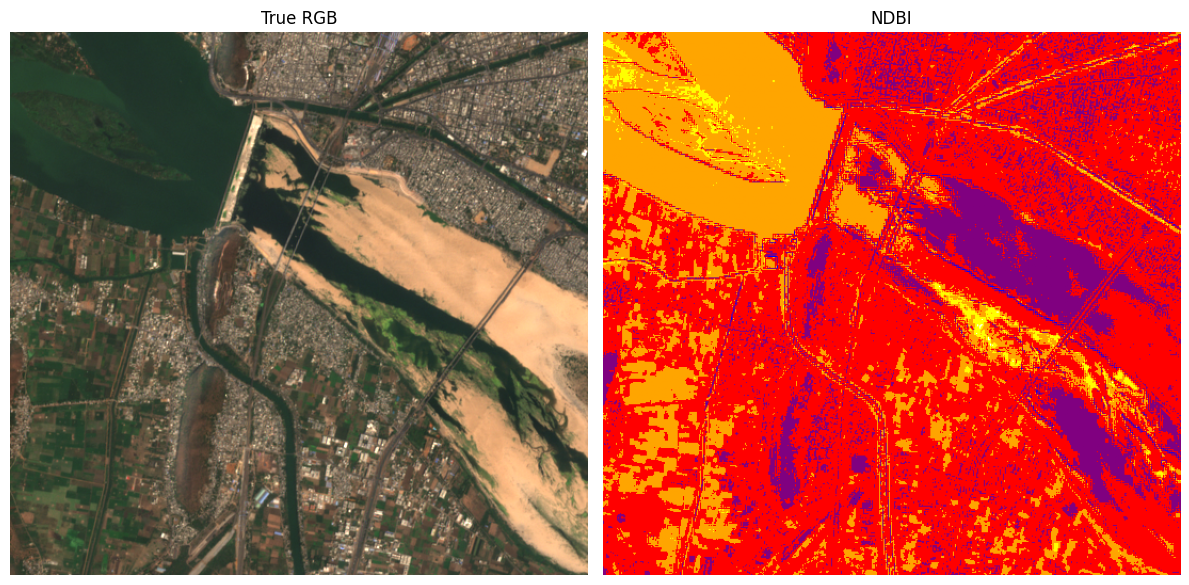

In [ ]:
import ee
import geemap
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from IPython.display import display

# Authenticate and initialize EE
ee.Authenticate()
ee.Initialize(project='ee-testinrightwaylc')

# Define coordinates (rectangle)
lon1, lat1 = 80.63592535074986, 16.471995519962046
lon2, lat2 = 80.58532815989292, 16.517938543927922
geometry = ee.Geometry.Rectangle([lon1, lat1, lon2, lat2])

# Load Sentinel-2 collection
collection = (
    ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
    .filterDate('2021-01-01', '2021-12-31')  # Using 2024 since 2025 is future
    .filterBounds(geometry)
    .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 10))
)
image = collection.sort("CLOUDY_PIXEL_PERCENTAGE").first()

# NDVI and NDWI calculations
ndbi = image.normalizedDifference(['B11', 'B8'])

# Define a 7-color palette with distinct colors
#Corrected the ndbi_palette with single '#'
ndbi_palette = ['#FFFFFF', '#FFFF00', '#FFA500', '#FF0000', '#800080', '#0000FF', '#008000']

# Generate thumbnail for visualization

# Convert hex palettes to matplotlib colormaps
ndbi_cmap = ListedColormap([f'{color}' if color.startswith('#') else color for color in ndbi_palette])


# Convert EE images to NumPy arrays
rgb_bands = image.select(['B4', 'B3', 'B2'])
rgb_array = geemap.ee_to_numpy(rgb_bands, region=geometry, scale=10)
ndbi_array = geemap.ee_to_numpy(ndbi, region=geometry, scale=10)

# Normalize RGB for display (0-1 range)
rgb_array = np.clip(rgb_array / 3000, 0, 1)  # Match original min: 0, max: 3000

# Create side-by-side plots
fig, axs = plt.subplots(1, 2, figsize=(12, 12))  # 2 rows, 2 columns

# Row 1: True RGB and NDVI
axs[0].imshow(rgb_array)
axs[0].set_title("True RGB")
axs[0].axis('off')

axs[1].imshow(ndbi_array, cmap=ndbi_cmap, vmin=-1, vmax=1)
axs[1].set_title("NDBI")
axs[1].axis('off')


# Adjust layout and display
plt.tight_layout()
plt.show()

In [ ]:
# total_pixels = np.count_nonzero(~np.isnan(ndvi_array))
# total_area_km2 = total_pixels * pixel_area_m2 / 1e6

In [ ]:
!pip install rasterio

In [ ]:
import ee
import geemap
import numpy as np
# import rasterio
# from rasterio.transform import from_bounds
import os
from IPython.display import display
import ipywidgets as widgets

# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize(project='ee-testinrightwaylc')

# Define the region of interest
lon1, lat1 = 80.58563253572738, 16.472595829903636
lon2, lat2 = 80.63850423982895, 16.5150620008198
geometry = ee.Geometry.Rectangle([lon1, lat1, lon2, lat2])

# Load Sentinel-2 harmonized collection
collection = (
    ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
    .filterDate('2021-01-01', '2021-12-31')
    .filterBounds(geometry)
    .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 10))
)

# Select the least cloudy image
image = collection.sort("CLOUDY_PIXEL_PERCENTAGE").first()

# Select bands: B1 (60m), B2, B3, B4, B8 (10m); B11, B12 (20m)
bands_10m = ['B2', 'B3', 'B4', 'B8']
bands_20m = ['B11', 'B12']
bands_60m = ['B1']

# Extract 10m resolution bands
image_10m = image.select(bands_10m)

# Upscale 20m and 60m bands to 10m using bilinear interpolation
image_20m = image.select(bands_20m).resample('bilinear').reproject(
    crs=image.select('B2').projection(),
    scale=10
)
image_60m = image.select(bands_60m).resample('bilinear').reproject(
    crs=image.select('B2').projection(),
    scale=10
)

# Combine all bands
image_all = image_10m.addBands(image_20m).addBands(image_60m).select(bands_60m + bands_10m + bands_20m)

# Normalize reflectance values to 0-1
image_all = image_all.divide(10000)

# Create an interactive map for labeling
Map = geemap.Map(center=[(lat1 + lat2) / 2, (lon1 + lon2) / 2], zoom=12)
Map.addLayer(image_all.select(['B4', 'B3', 'B2']), {'min': 0, 'max': 0.3}, 'True Color')
Map.addLayer(image_all.select(['B1', 'B2', 'B12']), {'min': 0, 'max': 0.3}, 'Water Bands (B1, B2, B12)')
Map.addLayer(image_all.select(['B11', 'B4', 'B2']), {'min': 0, 'max': 0.3}, 'Built-up Bands (B11, B4, B2)')

# Output directory for saving patches and labels
output_dir = 'landcover_data'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Lists to store patches and labels
patches = []
labels = []

# Widget for labeling
class_dropdown = widgets.Dropdown(
    options=[
        ('Built-up (Buildings, Roads)', 0),
        ('Barren Land (Sand, Soil)', 1),
        ('Vegetation', 2),
        ('Water', 3)
    ],
    value=0,
    description='Class:'
)
save_button = widgets.Button(description='Save Patch')
output_widget = widgets.Output()

# Function to handle click events for labeling
patch_size = 32  # 32x32 patches at 10m resolution
def handle_interaction(**kwargs):
    if kwargs.get('type') == 'click':
        coords = kwargs.get('coordinates')
        point = ee.Geometry.Point(coords[1], coords[0])  # [lon, lat]
        # Define a 32x32 pixel patch around the clicked point
        patch_geometry = point.buffer(patch_size * 5).bounds()  # 32 pixels * 10m/2
        # Sample the image patch
        try:
            patch = image_all.sampleRectangle(
                region=patch_geometry,
                defaultValue=0
            )
            # Extract band values as numpy arrays
            patch_data = {}
            for band in bands_60m + bands_10m + bands_20m:
                patch_data[band] = np.array(patch.get(band).getInfo())
            # Stack bands into a (32, 32, 7) array
            patch_array = np.stack([patch_data[band] for band in bands_60m + bands_10m + bands_20m], axis=-1)

            with output_widget:
                output_widget.clear_output()
                print(f"Clicked at: ({coords[1]:.6f}, {coords[0]:.6f})")
                print("Select class and click 'Save Patch'")
                # Store patch temporarily for saving
                global temp_patch
                temp_patch = patch_array
        except ee.EEException as e:
            with output_widget:
                output_widget.clear_output()
                print(f"Error sampling patch: {str(e)}")

# Function to save patch and label
def save_patch(b):
    if 'temp_patch' in globals() and temp_patch.shape == (patch_size, patch_size, 7):
        patches.append(temp_patch)
        labels.append(class_dropdown.value)
        # Save patch as GeoTIFF
        patch_num = len(patches)
        patch_file = os.path.join(output_dir, f'patch_{patch_num}.tif')
        transform = from_bounds(lon1, lat1, lon2, lat2, patch_size, patch_size)
        with rasterio.open(
            patch_file, 'w', driver='GTiff', height=patch_size, width=patch_size,
            count=7, dtype='float32', transform=transform
        ) as dst:
            for i in range(7):
                dst.write(patches[-1][:, :, i], i + 1)
        with output_widget:
            print(f"Saved patch {patch_num} with label {class_dropdown.value}")
    else:
        with output_widget:
            print("No valid patch to save. Click the map first.")

# Connect the save button
save_button.on_click(save_patch)

# Attach the click handler to the map
Map.on_interaction(handle_interaction)

# Display the map and widgets
display(Map)
display(widgets.VBox([class_dropdown, save_button, output_widget]))

# Save labels to a file
def save_labels():
    np.save(os.path.join(output_dir, 'labels.npy'), np.array(labels))
    print(f"Saved {len(labels)} labels to {output_dir}/labels.npy")

# Call this manually after labeling
# save_labels()

ModuleNotFoundError: No module named 'rasterio'